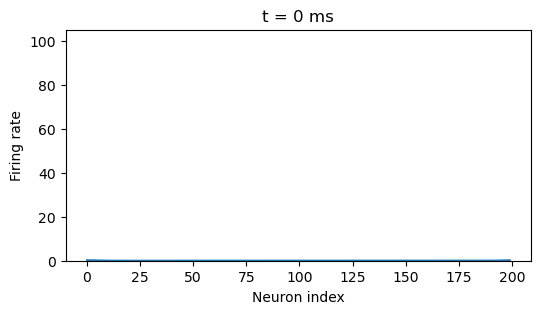

In [2]:
"""
Ring attractor network demo
Author: ChatGPT (July 2025)
-------------------------------------------------
• N excitatory neurons arranged on a ring.
• Mexican-hat–style connectivity: local excitation (Gaussian) + uniform inhibition.
• Simple rate-based dynamics integrated with Euler's method.
• A rotating external input ('visual landmark') shows how the bump follows a cue.
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -------------------------
# 1. Network parameters
# -------------------------
N          = 200               # number of neurons on the ring
tau        = 10.0              # membrane time constant (ms)
dt         = 1.0               # simulation step (ms)
T          = 4000              # total simulation time (ms)
time       = np.arange(0, T, dt)

# Connectivity: Gaussian excitation + global inhibition
sigma_exc  = 0.05 * N          # width (in neuron indices)
J_exc      = 1.0               # excitatory peak weight
J_inh      = -0.6              # uniform inhibitory weight

# External cue (rotates at constant angular velocity ω)
cue_amp    = 2.0               # amplitude of the cue
omega      = 2 * np.pi / 3000  # one full turn every 3 s

# Non-linearity (soft rectification)
def phi(h):
    return np.clip(h, 0, 100)  # ReLU with upper bound to prevent overflow

# -------------------------
# 2. Build weight matrix
# -------------------------
indices = np.arange(N)
dist    = np.minimum(np.abs(indices[:, None] - indices[None, :]),
                     N - np.abs(indices[:, None] - indices[None, :]))   # wrap-around distance
W       = J_exc * np.exp(-dist**2 / (2 * sigma_exc**2)) + J_inh         # shape (N, N)

# Normalize weights to prevent instability
W = W / np.max(np.abs(W))

# -------------------------
# 3. Simulation
# -------------------------
A  = np.zeros(N)                # initial firing rates
rec = []                        # activity history for plotting

for t in time:
    # External input: narrow Gaussian centred at angle θ(t)
    theta = (omega * t) % (2 * np.pi)
    pref_angles = 2 * np.pi * indices / N
    cue = cue_amp * np.exp(- (np.angle(np.exp(1j*(pref_angles - theta)))**2) / (2*(0.05*np.pi)**2))

    # Euler update with stability checks
    input_current = W @ A + cue
    input_current = np.clip(input_current, -100, 100)  # Prevent extreme values
    dA = (-A + phi(input_current)) * (dt / tau)
    A += dA
    rec.append(A.copy())

rec = np.stack(rec)             # shape (T/dt, N)

# -------------------------
# 4. Visualisation
# -------------------------
fig, ax = plt.subplots(figsize=(6, 3))
line, = ax.plot(rec[0])

# Set ylim only if we have valid data
if np.any(np.isfinite(rec)):
    valid_max = np.nanmax(rec[np.isfinite(rec)])
    ax.set_ylim(0, valid_max * 1.05)
else:
    ax.set_ylim(0, 1)  # Fallback limits

ax.set_xlabel('Neuron index')
ax.set_ylabel('Firing rate')
ax.set_title('Ring attractor activity bump')

def animate(frame):
    line.set_ydata(rec[frame])
    ax.set_title(f't = {frame*dt:0.0f} ms')
    return line,

ani = FuncAnimation(fig, animate, frames=len(time), interval=30, blit=True)
plt.show()
